<a href="https://colab.research.google.com/github/Smruthi3/END2/blob/main/END2/Session11-Assignment/Session11_Test_Assignment_Baby_Steps_to_Attention_LSTM_V4_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence to Sequence and Attention Mechanism

In this code we'll we will dig much deeper and try and come up with the model ourselves. We will see the steps required to do so. 

For the actual model refer to [this](https://colab.research.google.com/drive/1yyQw39zVJOHtJSivjJICR4AlH4U8JwQf?usp=sharing) colab link. 

The part we are going to borrow from the code above is the data-preprocessing as that is straight forward. 

In [ ]:
%matplotlib inline

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

!wget https://download.pytorch.org/tutorial/data.zip

!unzip data.zip

--2021-07-24 14:58:34--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.52.36, 13.226.52.51, 13.226.52.90, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.52.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  16.7MB/s    in 0.2s    

2021-07-24 14:58:34 (16.7 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italia

In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['tu me decois vraiment .', 'i m very disappointed in you .']


After all of these steps, our data is ready. Let's explore it a bit

In [ ]:
type(pairs)

list

In [ ]:
pairs[0:5]

[['j ai ans .', 'i m .'],
 ['je vais bien .', 'i m ok .'],
 ['ca va .', 'i m ok .'],
 ['je suis gras .', 'i m fat .'],
 ['je suis gros .', 'i m fat .']]

Cool, so our data is actually a list of list, and each innter list element consists of fra to eng translation. 

# The architecture we are building

![image](https://miro.medium.com/max/1838/1*tXchCn0hBSUau3WO0ViD7w.jpeg)

As we can see here, we will have an encoder, an attention mechanism block and decoder. In the final code the attention mechanicm block and decoder will be merged into single block as we need both to work together. 

As we can see here, we need to create a copy of h1, h2, h3 and h4. These are encoder outputs for a sentence with 4 words. 

# Encoder

We will build our encoder with a LSTM, but that's all we know. Let's NOT strait away build a class, but see how to come up with one for the Encoder. We need to answer few questions first:
1. what would be the hidden size of our LSTM
2. What would be the input size
3. What would be the embedding dimesions. 

For simplicity, lets keep 1. and 3. to be 256. 

We can't feed our input directly to LSTM, we need to tensorize it, convert to embeddings first. 

`embedding = nn.Embedding(input_size, hidden_size) `

## What is input_size?

Remember the line below?

`input_lang, output_lang, pairs = prepareData('eng', 'fra', True)`

In [ ]:
input_lang

Well that doesn't give us much. Let's dig into what it is. 

In [ ]:
help(input_lang)

Help on Lang in module __main__ object:

class Lang(builtins.object)
 |  Lang(name)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, name)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  addSentence(self, sentence)
 |  
 |  addWord(self, word)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [ ]:
input_lang.__dict__.items()

dict_items([('name', 'fra'), ('word2index', {'j': 2, 'ai': 3, 'ans': 4, '.': 5, 'je': 6, 'vais': 7, 'bien': 8, 'ca': 9, 'va': 10, 'suis': 11, 'gras': 12, 'gros': 13, 'en': 14, 'forme': 15, 'touche': 16, '!': 17, 'touchee': 18, 'malade': 19, 'triste': 20, 'timide': 21, 'mouille': 22, 'mouillee': 23, 'il': 24, 'est': 25, 'revenu': 26, 'me': 27, 'revoila': 28, 'chauve': 29, 'occupe': 30, 'occupee': 31, 'calme': 32, 'froid': 33, 'fini': 34, 'tout': 35, 'libre': 36, 'disponible': 37, 'repu': 38, 'rassasie': 39, 'content': 40, 'chez': 41, 'moi': 42, 'retard': 43, 'paresseux': 44, 'faineant': 45, 'paresseuse': 46, 'faineante': 47, 'porte': 48, 'securite': 49, 'certain': 50, 'sur': 51, 'sure': 52, 'grande': 53, 'mince': 54, 'ordonne': 55, 'ordonnee': 56, 'laid': 57, 'laide': 58, 'faible': 59, 'vieux': 60, 'dj': 61, 'bon': 62, 'riche': 63, 'ici': 64, 'flic': 65, 'un': 66, 'homme': 67, 'seule': 68, 'seul': 69, 'arme': 70, 'armee': 71, 'reveille': 72, 'aveugle': 73, 'fauche': 74, 'fou': 75, 'foll

In [ ]:
# just at the end we have what we want, the total nunber of words
input_lang.n_words

4345

We want to create an embedding layer that has embedding value for each of the word we have in out input layer. So...

In [ ]:
input_size = input_lang.n_words

hidden_size = 256

embedding = nn.Embedding(input_size, hidden_size)
lstm = nn.LSTM(hidden_size, hidden_size)

In [ ]:
device

device(type='cpu')

Cool, now we need to feed data to our LSTM. 
But what do we feed out embedding layer? 
Let's figure it out by trail and error. We have input in the form of pairs already. Let's start from there

In [ ]:
sample = random.choice(pairs)
sample

['tu es un de ces dragueurs !', 'you re such a flirt .']

In [ ]:
input_sentence = sample[0]
target_sentence = sample[1]

input_lang.word2index['elle']

119

In [ ]:
input_sentence

'tu es un de ces dragueurs !'

In [ ]:
target_sentence

'you re such a flirt .'

In [ ]:
for word in input_sentence.split(' '):
  print(word)

tu
es
un
de
ces
dragueurs
!


In [ ]:
input_indices = [input_lang.word2index[word] for word in input_sentence.split(' ')]
target_indices = [output_lang.word2index[word] for word in target_sentence.split(' ')]
input_indices, target_indices

([210, 211, 66, 101, 1384, 2222, 17], [129, 78, 653, 42, 1276, 4])

In [ ]:
target_indices

[129, 78, 653, 42, 1276, 4]



Let's attach our EOS index to these lists! 

In [ ]:
input_indices.append(EOS_token)
target_indices.append(EOS_token)
input_indices, target_indices

([210, 211, 66, 101, 1384, 2222, 17, 1], [129, 78, 653, 42, 1276, 4, 1])

Oh yes, these are still indeces (not words anymore), we first need to convert them to tensors. 

In the original code we wrote these 3 functions to take care of all the work we did till now. 

```
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)
```

In [ ]:
input_tensor = torch.tensor(input_indices, dtype=torch.long, device= device)
output_tensor = torch.tensor(target_indices, dtype=torch.long, device= device)

In [ ]:
input_tensor.shape

torch.Size([8])

In [ ]:
embedded_input = embedding(input_tensor)

So we moved our tensor to CUDA, but layers to CPU. Let's check and fix that. 

In [ ]:
input_tensor

tensor([ 210,  211,   66,  101, 1384, 2222,   17,    1])

In [ ]:
embedding = nn.Embedding(input_size, hidden_size).to(device)
lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=1).to(device)
#nn.LSTMCell(embedding_dim, self.hidden_dim)

In [ ]:
lstm

LSTM(256, 256)

In [ ]:
embedded_input = embedding(input_tensor[0]) #first word only
embedded_input.shape

torch.Size([256])



We are working with 1 sample, but we would be working for a batch. Let's fix that by converting our input_tensor into a fake batch

In [ ]:
input_tensor.shape, input_tensor.view(-1, 1).shape

(torch.Size([8]), torch.Size([8, 1]))

In [ ]:
print(embedded_input.shape)
embedded_input = embedding(input_tensor[0].view(-1, 1))
print(embedded_input.shape)

torch.Size([256])
torch.Size([1, 1, 256])





Let's quickly build our LSTM now...
output, (hidden,cell_state) = lstm(embedded_input, WHAT WOULD COME HERE?)

We need an empty state. So let's create that first

In [ ]:
hidden = torch.zeros(1,1, 256, device=device)
cell_state = torch.zeros(1,1, 256, device=device)

# now this 1, 1 should be clear.. Look at the embedded input.. 
# those are 9 inputs cos we have 9 words in our sentence.. 
# hidden need to be a rank 3 tensor

In [ ]:
hidden.shape

torch.Size([1, 1, 256])

In [ ]:
embedded_input = embedding(input_tensor[0].view(-1, 1))

# for i in range(0,input_tensor.shape[0]):
output, (hidden,cell_state) = lstm(embedded_input, (hidden,cell_state))

In [ ]:
hidden

tensor([[[-0.0090,  0.0585,  0.2581, -0.2039,  0.1050,  0.0438,  0.1437,
          -0.1413, -0.0126, -0.1343, -0.1407, -0.1223,  0.0055,  0.0284,
           0.1235,  0.1040,  0.0658, -0.0108, -0.1804,  0.1848, -0.1541,
           0.1659, -0.1341,  0.1742,  0.0843,  0.0667, -0.0465,  0.0183,
           0.0732,  0.1766, -0.0102, -0.0534,  0.0401, -0.0870, -0.0863,
           0.2883,  0.1765,  0.0671, -0.1001, -0.0790, -0.1061,  0.0704,
          -0.0821,  0.0120, -0.1344, -0.0764,  0.0512, -0.0202,  0.2340,
          -0.1090, -0.2128,  0.1336, -0.0613,  0.1281,  0.0887,  0.2501,
          -0.0129,  0.0539,  0.0299, -0.1930, -0.0414,  0.0954,  0.0594,
           0.1375, -0.2118, -0.0687, -0.0622, -0.0313, -0.0432, -0.0241,
           0.1252,  0.1366,  0.2641,  0.2551, -0.0894, -0.0205,  0.0205,
           0.1381,  0.1360,  0.1272,  0.0051, -0.0658, -0.0689,  0.0614,
          -0.1248,  0.0495,  0.1051, -0.0871,  0.1021, -0.1121,  0.1645,
           0.0547, -0.2614, -0.0327, -0.1457, -0.01

WE have just cycled through our first word. Now we need to do it for the rest of the words. All we need finally is the list of ourputs. Let's create an empty tensor to store them. 

In [ ]:
output.shape, output[0, 0].shape

(torch.Size([1, 1, 256]), torch.Size([256]))

In [ ]:
encoder_outputs = torch.zeros(MAX_LENGTH, 256, device=device)
encoder_outputs.shape

torch.Size([10, 256])

In [ ]:
input_tensor.size(), input_tensor.size()[0]

(torch.Size([8]), 8)

In [ ]:
encoder_outputs = torch.zeros(MAX_LENGTH, 256, device=device)
encoder_hidden = torch.zeros(1, 1, 256, device=device)
encoder_cell_state = torch.zeros(1, 1, 256, device=device)

for i in range(input_tensor.size()[0]):
  embedded_input = embedding(input_tensor[i].view(-1, 1))
  output, (encoder_hidden,encoder_cell_state) = lstm(embedded_input, (encoder_hidden,encoder_cell_state))
  #encoder_outputs[i] += output[0,0]
  if(i!=(input_tensor.size()[0])-1):
    print(f'Printing encoder values after {i} word')
    print(input_sentence.split(" ")[i], input_tensor[i])
    print(encoder_hidden[0,0])
  encoder_outputs[i] += encoder_hidden[0,0]

Printing encoder values after 0 word
tu tensor(210)
tensor([-4.5550e-02,  3.6343e-02,  2.1735e-01,  6.1336e-03,  4.1104e-01,
         1.7859e-01,  7.2878e-02,  2.1786e-02,  1.6791e-01,  1.7623e-01,
         6.5995e-02, -1.9980e-02, -4.4284e-02,  7.7091e-02, -2.2929e-01,
         1.2835e-01,  3.1898e-02,  5.0700e-02,  5.4039e-02, -3.4020e-02,
        -1.1980e-01,  8.7015e-02, -6.1777e-02, -1.3783e-01,  4.3493e-02,
         1.4703e-01, -3.8862e-02,  5.3029e-02,  1.5306e-01,  4.5969e-02,
        -1.0209e-01,  7.2528e-02, -5.7598e-02,  2.7862e-01, -6.7455e-02,
         2.0120e-01, -4.0555e-02,  2.8564e-01, -1.2964e-01,  2.9948e-01,
         5.5508e-02, -1.6607e-01,  1.8084e-01, -6.5003e-02, -1.4815e-01,
        -2.2861e-01,  7.3803e-02,  3.1959e-01,  4.2142e-03, -1.0943e-01,
         7.4164e-02, -1.6741e-02, -2.9323e-02,  8.5584e-02,  9.6427e-02,
         2.9490e-03,  6.8361e-02,  3.8581e-01,  1.8376e-01,  7.0986e-02,
         1.9817e-02, -7.3547e-02,  7.6909e-03,  2.5289e-01,  3.9373e-02,

In [ ]:
encoder_outputs.shape, encoder_hidden.shape

(torch.Size([10, 256]), torch.Size([1, 1, 256]))

In [ ]:
output.shape

torch.Size([1, 1, 256])

In [ ]:
encoder_outputs[0:4]

tensor([[-0.0090,  0.0585,  0.2581,  ...,  0.0283, -0.2182,  0.0445],
        [-0.1590, -0.0903,  0.2652,  ...,  0.0160, -0.1945, -0.0623],
        [-0.1437, -0.1361,  0.2042,  ...,  0.0287,  0.0752,  0.1000],
        [-0.1655,  0.0199,  0.2864,  ..., -0.0444,  0.0425, -0.0738]],
       grad_fn=<SliceBackward>)

In [ ]:
encoder_outputs[7:10]

tensor([[-0.1889, -0.0540, -0.0039,  0.0164,  0.1833,  0.0023,  0.1334,  0.1169,
          0.0339,  0.0552,  0.0291,  0.1667,  0.1388, -0.0740,  0.0260, -0.1575,
         -0.3649,  0.0064,  0.0155,  0.3125, -0.1670,  0.1471,  0.0560,  0.0985,
         -0.1469, -0.0907, -0.0037, -0.0889,  0.2039,  0.1004,  0.2053,  0.1767,
         -0.0635, -0.1660,  0.2657, -0.0012, -0.0238,  0.0661, -0.1160, -0.0464,
          0.0934,  0.0607, -0.1797, -0.0368,  0.1538,  0.0698,  0.0268,  0.1921,
          0.1009,  0.1085, -0.1817,  0.0787, -0.1138, -0.3145,  0.0419,  0.0028,
          0.0511,  0.1120,  0.1331, -0.1635, -0.1395,  0.2676,  0.3138,  0.0867,
         -0.1096, -0.0660, -0.0241, -0.0263,  0.1202, -0.0468,  0.0336,  0.1028,
          0.1041,  0.0296,  0.1523,  0.0991, -0.1169,  0.0700, -0.0496, -0.1493,
          0.1534,  0.2230, -0.1863, -0.0727, -0.2299,  0.0922,  0.0993, -0.1755,
         -0.0812,  0.0825, -0.0714,  0.1216, -0.0511,  0.1838, -0.2030,  0.0151,
         -0.1383,  0.1384,  



Finally our Encoder is fully ready. Now let's look at the class we wrote in the last class to see what we missed!

```
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, (hidden,cell) = self.lstm(output, (hidden,hidden))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
```

Cool! Next let's build out Decoder where we have attention in-built.

# Decoder with Attention

Here is the plan. 

1. First input to the decoder will be SOS_token, later inputs would be the words it predicted (unless we implement teacher forcing)
2. decoder/LSTM's hidden state will be initialized with the encoder's last hidden state
3. we will use LSTM's hidden state and last prediction to generate attention weight using a FC layer. 
4. this attention weight will be used to weigh the encoder_outputs using batch matric multiplication. This will give us a NEW view on how to look at encoder_states.
5. this attention applied encoder_states will then be concatenated with the input, and then sent a linear layer and _then_ sent to the LSTM. 
6. LSTM's output will be sent to a FC layer to predict one of the output_language words

Let's prepare all the inputs we need to do this


In [ ]:
# first input
decoder_input = torch.tensor([[SOS_token]], device=device)
decoder_hidden = encoder_hidden
decoded_words = []

In [ ]:
output_size = output_lang.n_words

embedding = nn.Embedding(output_size, 256).to(device)

In [ ]:
embedded = embedding(decoder_input)
embedded.shape

torch.Size([1, 1, 256])

In [ ]:
attn_weight_layer = nn.Linear(256 * 2, 10).to(device)

In [ ]:
embedded.shape, decoder_hidden.shape

(torch.Size([1, 1, 256]), torch.Size([1, 1, 256]))

In [ ]:
torch.cat((embedded, decoder_hidden), 1).shape

torch.Size([1, 2, 256])

We don't want that. We wanted to concatenate them. 

In [ ]:
torch.cat((embedded[0], decoder_hidden[0]), 1).shape

torch.Size([1, 512])

In [ ]:
attn_weight_layer = nn.Linear(256 * 2, 10).to(device)
attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
attn_weights

tensor([[-7.5995e-01, -7.6951e-01,  3.6280e-04,  3.7044e-01,  1.5908e-01,
          5.1953e-01,  3.4279e-01,  3.3754e-02,  2.2608e-01,  2.9932e-01]],
       grad_fn=<AddmmBackward>)

Let's take Softmax of these weights. 

In [ ]:
import torch.nn.functional as F

attn_weight_layer = nn.Linear(256 * 2, 10).to(device)
attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
attn_weights = F.softmax(attn_weights, dim = 1)
attn_weights

tensor([[0.0805, 0.0672, 0.0937, 0.1484, 0.1337, 0.1852, 0.1087, 0.0453, 0.0646,
         0.0727]], grad_fn=<SoftmaxBackward>)

Now let's **apply** this attention to the encoder_inputs

In [ ]:
attn_weights.shape, encoder_outputs.shape

(torch.Size([1, 10]), torch.Size([10, 256]))

We need to think about the batch, and then our 2D data for matrix multiplication

In [ ]:
attn_weights.unsqueeze(0).shape, encoder_outputs.unsqueeze(0).shape

(torch.Size([1, 1, 10]), torch.Size([1, 10, 256]))

In [ ]:
attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
attn_applied.shape

torch.Size([1, 1, 256])

So, now we have this 256dm attn_applied encoder_outputs capturing what we should focus on on this step. We also have the input we already generated. That's 256dm again. GRU is gonna take 256 only. So we need to concatenate them, send to a linear layer to reduce dimensions, and then send to LSTM.
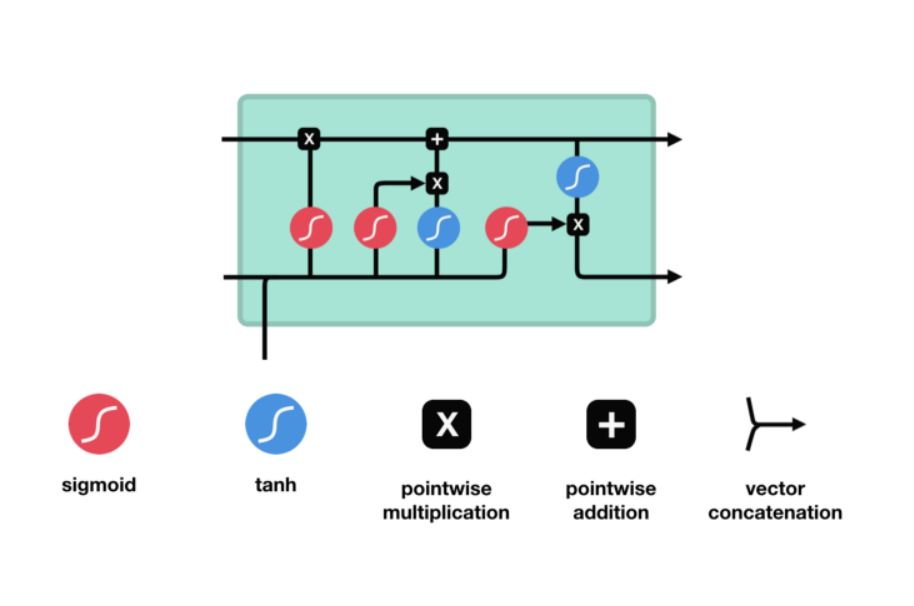


In [ ]:
input_to_lstm_layer = nn.Linear(256 * 2, 256).to(device)

embedded.shape, attn_applied.shape

(torch.Size([1, 1, 256]), torch.Size([1, 1, 256]))

In [ ]:
torch.cat((embedded, attn_applied), 1).shape, torch.cat((embedded[0], attn_applied[0]), 1).shape

(torch.Size([1, 2, 256]), torch.Size([1, 512]))

In [ ]:
input_to_lstm = input_to_lstm_layer(torch.cat((embedded[0], attn_applied[0]), 1))
input_to_lstm.shape

torch.Size([1, 256])

In [ ]:
lstm = nn.LSTM(256, 256).to(device)

In [ ]:
decoder_hidden.shape, input_to_lstm.shape

(torch.Size([1, 1, 256]), torch.Size([1, 256]))

In [ ]:
input_to_lstm = input_to_lstm.unsqueeze(0)
decoder_hidden.shape, input_to_lstm.shape

(torch.Size([1, 1, 256]), torch.Size([1, 1, 256]))

In [ ]:
output, (decoder_hidden,decoder_cell_state) = lstm(input_to_lstm, (decoder_hidden,decoder_hidden))
output.shape, decoder_hidden.shape,decoder_cell_state.shape

(torch.Size([1, 1, 256]), torch.Size([1, 1, 256]), torch.Size([1, 1, 256]))

In [ ]:
output_word_layer = nn.Linear(256, output_lang.n_words).to(device)

In [ ]:
output = F.relu(output)
output = F.softmax(output_word_layer(output[0]), dim = 1)
output, output.shape

(tensor([[0.0003, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004]],
        grad_fn=<SoftmaxBackward>), torch.Size([1, 2803]))

In [ ]:
output.data.topk(1)

torch.return_types.topk(values=tensor([[0.0004]]), indices=tensor([[1298]]))

In [ ]:
top_value, top_index = output.data.topk(1)
output_lang.index2word[top_index.item()]

'precious'


Let's combine all of these steps, we we have just processed 1 input till now. 

In [ ]:
top_index.item()

1298

In [ ]:
decoder_input = torch.tensor([[SOS_token]], device=device)
decoder_hidden = encoder_hidden
output_size = output_lang.n_words
embedding = nn.Embedding(output_size, 256).to(device)
embedded = embedding(decoder_input)
attn_weight_layer = nn.Linear(256 * 2, 10).to(device)
attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
attn_weights = F.softmax(attn_weights, dim = 1)
attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
input_to_lstm_layer = nn.Linear(256 * 2, 256).to(device)
input_to_lstm = input_to_lstm_layer(torch.cat((embedded[0], attn_applied[0]), 1))
lstm = nn.LSTM(256, 256).to(device)
input_to_lstm = input_to_lstm.unsqueeze(0)
output, (decoder_hidden,decoder_cell_state) = lstm(input_to_lstm, (decoder_hidden,decoder_hidden))
output_word_layer = nn.Linear(256, output_lang.n_words).to(device)
#output = F.relu(output)
output = F.relu(decoder_hidden)
output = F.softmax(output_word_layer(output[0]), dim = 1)
top_value, top_index = output.data.topk(1)
output_lang.index2word[top_index.item()]

'allow'

In [ ]:
output_size

2803

In [ ]:
embedding = nn.Embedding(output_size, 256).to(device)
attn_weight_layer = nn.Linear(256 * 2, 10).to(device)
input_to_lstm_layer = nn.Linear(256 * 2, 256).to(device)
lstm = nn.LSTM(256, 256).to(device)
output_word_layer = nn.Linear(256, output_lang.n_words).to(device)


decoder_input = torch.tensor([[SOS_token]], device=device)
decoder_hidden = encoder_hidden
output_size = output_lang.n_words
embedded = embedding(decoder_input)
attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
attn_weights = F.softmax(attn_weights, dim = 1)
attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
input_to_lstm = input_to_lstm_layer(torch.cat((embedded[0], attn_applied[0]), 1))
input_to_lstm = input_to_lstm.unsqueeze(0)
output, (decoder_hidden,decoder_cell) = lstm(input_to_lstm, (decoder_hidden,decoder_hidden))
#output = F.relu(output)
output = F.relu(decoder_hidden)
output = F.softmax(output_word_layer(output[0]), dim = 1)
top_value, top_index = output.data.topk(1)
output_lang.index2word[top_index.item()], attn_weights

('kindness',
 tensor([[0.0573, 0.1400, 0.0587, 0.0499, 0.1278, 0.1714, 0.1208, 0.0946, 0.1059,
          0.0736]], grad_fn=<SoftmaxBackward>))

In [ ]:
top_index

tensor([[2725]])

In [ ]:
device

device(type='cpu')

In [ ]:
embedded[0].shape,decoder_hidden[0].shape

(torch.Size([1, 256]), torch.Size([1, 256]))

In [ ]:
torch.cat((embedded[0], attn_applied[0]), 1).shape

torch.Size([1, 512])

In [ ]:
decoder_input = torch.tensor([[top_index.item()]], device=device)
decoder_hidden = encoder_hidden
output_size = output_lang.n_words
embedded = embedding(decoder_input)
attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
attn_weights = F.softmax(attn_weights, dim = 1)
attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
input_to_lstm = input_to_lstm_layer(torch.cat((embedded[0], attn_applied[0]), 1))
input_to_lstm = input_to_lstm.unsqueeze(0)
output, (decoder_hidden,decoder_cell) = lstm(input_to_lstm, (decoder_hidden,decoder_hidden))
#output = F.relu(output)
output = F.relu(decoder_hidden)
output = F.softmax(output_word_layer(output[0]), dim = 1)
top_value, top_index = output.data.topk(1)
output_lang.index2word[top_index.item()], attn_weights

('she',
 tensor([[0.1399, 0.0630, 0.0721, 0.1543, 0.1113, 0.0905, 0.0926, 0.0917, 0.1154,
          0.0692]], grad_fn=<SoftmaxBackward>))

In [ ]:
target_indices

[129, 78, 653, 42, 1276, 4, 1]

In [ ]:
decoder_input = torch.tensor([[target_indices[6]]], device=device)
decoder_hidden = encoder_hidden
output_size = output_lang.n_words
embedded = embedding(decoder_input)
attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
attn_weights = F.softmax(attn_weights, dim = 1)
attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
input_to_lstm = input_to_lstm_layer(torch.cat((embedded[0], attn_applied[0]), 1))
input_to_lstm = input_to_lstm.unsqueeze(0)
output, (decoder_hidden,decoder_cell) = lstm(input_to_lstm, (decoder_hidden,decoder_hidden))
#output = F.relu(output)
output = F.relu(decoder_hidden)
output = F.softmax(output_word_layer(output[0]), dim = 1)
top_value, top_index = output.data.topk(1)
output_lang.index2word[top_index.item()], attn_weights

('thieves',
 tensor([[0.0765, 0.1132, 0.0584, 0.1341, 0.0877, 0.0776, 0.0785, 0.1467, 0.1364,
          0.0910]], grad_fn=<SoftmaxBackward>))

In [ ]:
for i in range(4):
  print(i)

0
1
2
3


In [ ]:
target_indices

[129, 78, 653, 42, 1276, 4, 1]

In [ ]:
target_sentence.split(" ")

['you', 're', 'such', 'a', 'flirt', '.']

In [ ]:
 target_indices

[129, 78, 653, 42, 1276, 4, 1]

In [ ]:
for i in range(6):
  decoder_input = torch.tensor([[target_indices[i]]], device=device)
  decoder_hidden = encoder_hidden
  output_size = output_lang.n_words
  embedded = embedding(decoder_input)
  attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
  attn_weights = F.softmax(attn_weights, dim = 1)
  attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
  input_to_lstm = input_to_lstm_layer(torch.cat((embedded[0], attn_applied[0]), 1))
  input_to_lstm = input_to_lstm.unsqueeze(0)
  output, (decoder_hidden,decoder_cell) = lstm(input_to_lstm, (decoder_hidden,decoder_hidden))
  #output = F.relu(output)
  output = F.relu(decoder_hidden)
  output = F.softmax(output_word_layer(output[0]), dim = 1)
  top_value, top_index = output.data.topk(1)
  print(target_sentence.split(" ")[i], target_indices[i], output_lang.index2word[top_index.item()], top_index.item() )
  print(attn_weights)

you 129 mad 185
tensor([[0.1765, 0.0310, 0.1310, 0.1059, 0.1243, 0.0880, 0.0824, 0.1015, 0.1117,
         0.0477]], grad_fn=<SoftmaxBackward>)
re 78 reliable 286
tensor([[0.1181, 0.0574, 0.0806, 0.0707, 0.0587, 0.1297, 0.0940, 0.1965, 0.0892,
         0.1051]], grad_fn=<SoftmaxBackward>)
such 653 traffic 2050
tensor([[0.1536, 0.0841, 0.1154, 0.0746, 0.1202, 0.0734, 0.1679, 0.0612, 0.0913,
         0.0582]], grad_fn=<SoftmaxBackward>)
a 42 thieves 1250
tensor([[0.1753, 0.0510, 0.0955, 0.0536, 0.0413, 0.1012, 0.0875, 0.1800, 0.1447,
         0.0699]], grad_fn=<SoftmaxBackward>)
flirt 1276 underwear 1197
tensor([[0.0562, 0.1398, 0.1267, 0.0726, 0.0280, 0.0874, 0.0484, 0.2893, 0.0817,
         0.0700]], grad_fn=<SoftmaxBackward>)
. 4 thieves 1250
tensor([[0.0541, 0.0566, 0.1810, 0.0545, 0.1737, 0.0661, 0.0864, 0.1412, 0.0626,
         0.1239]], grad_fn=<SoftmaxBackward>)


In [ ]:
target_indices, target_sentence, input_sentence

([129, 78, 653, 42, 1276, 4, 1],
 'you re such a flirt .',
 'tu es un de ces dragueurs !')

In [ ]:
for i in range(6):
  decoder_input = torch.tensor([[target_indices[i]]], device=device)
  decoder_hidden = encoder_hidden
  output_size = output_lang.n_words
  embedded = embedding(decoder_input)
  attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
  attn_weights = F.softmax(attn_weights, dim = 1)
  attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
  input_to_lstm = input_to_lstm_layer(torch.cat((embedded[0], attn_applied[0]), 1))
  input_to_lstm = input_to_lstm.unsqueeze(0)
  output, (decoder_hidden,decoder_cell) = lstm(input_to_lstm, (decoder_hidden,decoder_hidden))
  #output = F.relu(output)
  output = F.relu(decoder_hidden)
  output = F.softmax(output_word_layer(output[0]), dim = 1)
  top_value, top_index = output.data.topk(1)
  print(target_sentence.split(" ")[i], target_indices[i], output_lang.index2word[top_index.item()], top_index.item() )
  print(f'Printing the attention weights {attn_weights}')
  print(f'Printing the output of decoder for each word {output}')

you 129 unemployed 530
Printing the attention weights tensor([[0.1921, 0.0312, 0.1231, 0.1107, 0.1091, 0.0976, 0.0888, 0.0949, 0.1012,
         0.0514]], grad_fn=<SoftmaxBackward>)
Printing the output of decoder for each word tensor([[0.0004, 0.0003, 0.0004,  ..., 0.0003, 0.0004, 0.0003]],
       grad_fn=<SoftmaxBackward>)
re 78 wandering 2595
Printing the attention weights tensor([[0.1272, 0.0572, 0.0749, 0.0732, 0.0509, 0.1424, 0.1002, 0.1818, 0.0800,
         0.1121]], grad_fn=<SoftmaxBackward>)
Printing the output of decoder for each word tensor([[0.0004, 0.0004, 0.0004,  ..., 0.0003, 0.0004, 0.0003]],
       grad_fn=<SoftmaxBackward>)
such 653 awesome 418
Printing the attention weights tensor([[0.1657, 0.0839, 0.1075, 0.0773, 0.1046, 0.0807, 0.1794, 0.0567, 0.0820,
         0.0622]], grad_fn=<SoftmaxBackward>)
Printing the output of decoder for each word tensor([[0.0004, 0.0004, 0.0004,  ..., 0.0003, 0.0004, 0.0003]],
       grad_fn=<SoftmaxBackward>)
a 42 faced 2648
Printing the 

# Now let's combine everything together

In [ ]:
%matplotlib inline

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip

!unzip data.zip

--2021-07-24 15:44:34--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.52.128, 13.226.52.90, 13.226.52.36, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.52.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]   2.75M  16.8MB/s    in 0.2s    

2021-07-24 15:44:35 (16.8 MB/s) - ‘data.zip.1’ saved [2882130/2882130]

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/eng-fra.txt        
replace data/names/Arabic.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/names/Arabic.txt   
replace data/names/Chinese.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/names/Chinese.txt  
replace data/names/Czech.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/names/Czech.txt    
replace data/name

In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je me trouve pres de la gare .', 'i am near the station .']


The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A [Sequence to Sequence network](https://arxiv.org/abs/1409.3215), or
seq2seq network, or [Encoder Decoder
network](https://arxiv.org/pdf/1406.1078v3.pdf), is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

![image](https://pytorch.org/tutorials/_images/seq2seq.png)

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

![image](https://pytorch.org/tutorials/_images/encoder-network.png)

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output,(hidden,cell_state) = lstm(output,( hidden,hidden))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Attention Decoder

If only the context vector is passed between the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

![image](https://i.imgur.com/1152PYf.png)

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

![image](https://pytorch.org/tutorials/_images/attention-decoder-network.png)





In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output,(hidden,cell_state) = lstm(output,( hidden,hidden))

        output = F.log_softmax(self.out(hidden[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in `Effective Approaches to Attention-based Neural Machine
  Translation <https://arxiv.org/abs/1508.04025>`__.</p></div>

Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but [when the trained network is exploited, it may exhibit instability](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf).

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))



The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single LSTM layer. 

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

3m 52s (- 54m 18s) (5000 6%) 3.4059
7m 53s (- 51m 20s) (10000 13%) 2.9601
11m 58s (- 47m 54s) (15000 20%) 2.7313
16m 2s (- 44m 6s) (20000 26%) 2.6511
19m 56s (- 39m 52s) (25000 33%) 2.5791
23m 47s (- 35m 40s) (30000 40%) 2.5133
27m 46s (- 31m 44s) (35000 46%) 2.5054
31m 45s (- 27m 46s) (40000 53%) 2.4587
35m 42s (- 23m 48s) (45000 60%) 2.3938
39m 40s (- 19m 50s) (50000 66%) 2.3973
43m 40s (- 15m 52s) (55000 73%) 2.3884
47m 42s (- 11m 55s) (60000 80%) 2.3268
51m 44s (- 7m 57s) (65000 86%) 2.3443
55m 45s (- 3m 58s) (70000 93%) 2.3122
59m 50s (- 0m 0s) (75000 100%) 2.2783


In [ ]:
evaluateRandomly(encoder1, attn_decoder1)

> je suis heureux que vous veniez .
= i m glad you re coming .
< i m glad you re here . <EOS>

> tu es une opportuniste .
= you re opportunistic .
< you re very . . <EOS>

> je ne suis pas du matin .
= i m not a morning person .
< i m not a . . <EOS>

> c est un etudiant paresseux .
= he is a lazy student .
< he s a a . . <EOS>

> tu n es d aucune aide .
= you re no help .
< you re the aren t you ? <EOS>

> il souffre d une maladie grave .
= he is suffering from a serious illness .
< he s a to his . <EOS>

> je vais etre ici .
= i m going to be over here .
< i m very of you . <EOS>

> je ne suis toujours pas impressionne .
= i m still not impressed .
< i m not a to . <EOS>

> j en suis vraiment fiere .
= i m really proud of this .
< i m a little . <EOS>

> je suis desole de vous avoir deranges !
= i m sorry to have bothered you .
< i m glad to see you . <EOS>



Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




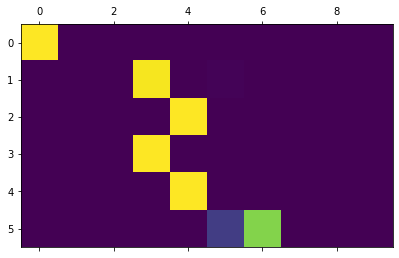

In [ ]:
%matplotlib inline
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes
and labels:

input = elle a cinq ans de moins que moi .
output = she s a to . than you . <EOS>


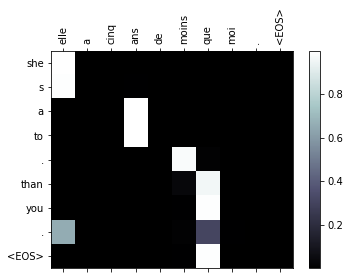

input = elle est trop petit .
output = she s the one . <EOS>


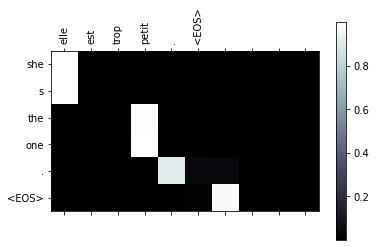

input = je ne crains pas de mourir .
output = i m not a . . <EOS>


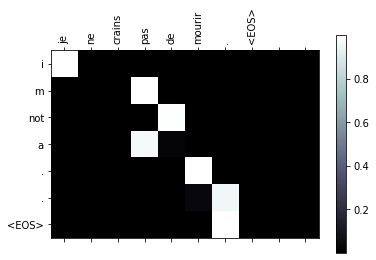

input = c est un jeune directeur plein de talent .
output = he s a a . . . <EOS>


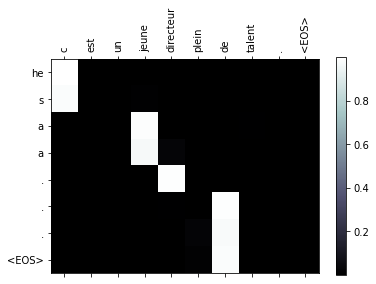

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")